# <center>Analyzing COVID-19 Vaccines Tweets<center>

## Streaming Live Tweets on Certain dates

Tweets will be streamed on different dates and stored into a text file, we streamed on two days, on February 21 and 23 2021. We  put several key words about the vaccines(tried to specify it to Lebanon since the geo argument and the key terms do not work together in tweepy), we specified the langauges to be Arabic and English, we stored the files into one text file for retrival.

The keys are considered private codes and need to be obtained by Twitter, that is why they were coded as stars.

In [ ]:
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream 
import json

#access keys from twitter
consumer_key = '********************'
consumer_key_secret = '**************************'
token_key = '***********************************'
token_secert = '**************************'

#define the stream function
class TwitterStreamer():
    def stream_tweets(self, file_name, hash_tag_list):
        listener = StdOutListener(file_name)
        auth = OAuthHandler(consumer_key, consumer_key_secret)
        auth.set_access_token(token_key, token_secert)
        stream = Stream(auth, listener)
        stream.filter(track = hash_tag_list, languages = ['en', 'ar'])
class StdOutListener(StreamListener):
    def __init__(self, file_name):
        self.file_name = file_name
    def on_data(self, data):
        try:
            print(data)
            with open(self.file_name, 'a') as tf:
                    tf.write(data)
            return True
        except BaseException as e:
            print('Error on_data: %s' % str(e))
        return True
    def on_error(self, status):
        print(status)

if __name__=='__main__':
    hash_tag_list = ['Corona vaccines', 'Lebanon vaccines', 'Pfizer Lebanon', 'لقاحات لبنان', 'لقاح كورونا لبنان', 'Covid19 vaccines']
    file_name = "data.txt"
    
    twitter_streamer = TwitterStreamer()
    twitter_streamer.stream_tweets(file_name, hash_tag_list)


## Reading the text file into JSON and extracting specific data that we choose to analyze

We converted the combined data text file into a json file, then we inspected the first tweet to extract the data that we want from the tweets. We got the text, truncated, location, quote_count, reply_count, retweet_count, favorite_count, and language.

Note that we tried to get the extended text for full tweet if exists, otherwise we got the truncated one, same applies for counts.
Also, we got the location as defined by the user at the time the tweet was written not the actual location defined by twitter as many users do not enable their location on their phones, which means that twitter can not detect their location. 

In [1]:
#import libraries
import pandas as pd
import csv
import json
import re

#coverting the text into json 
tweets_data_path = "data.txt"  
tweets_data = []  
tweets_file = open(tweets_data_path, "r")  
for line in tweets_file:  
    try:  
        tweet = json.loads(line)  
        tweets_data.append(tweet)  
    except:  
        continue
tweets_file.close()

In [ ]:
#inspect the first tweet
tweets_data[0]

In [ ]:
#extract relevant information for analysis 
tweets = pd.DataFrame()
tweets['text'] = list(map(lambda tweet: tweet['text'] if 'extended_tweet' not in tweet else tweet ['extended_tweet']['full_text'], tweets_data))
tweets['truncated'] = list(map(lambda tweet: tweet['truncated'], tweets_data))
tweets['location'] = list(map(lambda tweet: tweet['user']['location'], tweets_data))
tweets['quote_count'] = list(map(lambda tweet: tweet['quote_count'] if 'retweeted_status' not in tweet else tweet ['retweeted_status']['quote_count'], tweets_data))
tweets['reply_count'] = list(map(lambda tweet: tweet['reply_count'] if 'retweeted_status' not in tweet else tweet ['retweeted_status']['reply_count'], tweets_data))
tweets['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'] if 'retweeted_status' not in tweet else tweet ['retweeted_status']['retweet_count'], tweets_data))
tweets['favorite_count'] = list(map(lambda tweet: tweet['favorite_count'] if 'retweeted_status' not in tweet else tweet ['retweeted_status']['favorite_count'], tweets_data))
tweets['language'] = list(map(lambda tweet: tweet['lang'], tweets_data))
tweets.shape
tweets

we noticed that some tweet were fetched in different languages but we are only interested in arabic and english tweets.

In [ ]:
#extract tweets in english and arabic languages 
data = tweets[(tweets['language'] == 'ar') | (tweets['language'] == 'en')]

In [ ]:
#save data to csv for cleaning and analyzing
data.to_csv('data.csv', index=None)

## Cleaning the entire dataset

We can either reload the data as done below or we can clean it directly.

We will drop columns that we don't need, change columns names, change columns type, fill missing data, remove outliers, and clean the tweets from emojies, hashtages, mentions, and other characters.

In [53]:
#load the data
data = pd.read_csv('data.csv')

data.head()

,text,truncated,location,quote_count,reply_count,retweet_count,favorite_count,language
0,RT @Jscott916: @Geega1st @AynRandPaulRyan @th3...,False,NaN,0,0,1,1,en
1,RT @DrEricDing: Sweden 🇸🇪 strategy success??? ...,False,Here and there.,261,156,1791,3925,en
2,RT @N_ProudTegryan: @jaketapper Dear @jaketapp...,False,NaN,0,0,1,1,en
3,@JamesWard73 @bealelab @BristOliver Active sup...,True,UK,0,0,0,0,en
4,RT @washingtonpost: Winter storms delay distri...,False,"Chicago, IL",0,12,39,96,en


In [54]:
#drop truncated since it will not benefit us in the analysis 

data.drop('truncated', axis=1, inplace=True) 

#renaming column text 
data.rename(columns= {'text': 'full_tweets'}, inplace = True)
#change data type into string
data['full_tweets']= data['full_tweets'].astype('str') 

In [57]:
#check for missing values and fill them 
data['location'].isna()
data['location'].fillna('unknown', inplace = True)

In [60]:
#check for Q1,Q2, and Q3
data.describe()

,quote_count,reply_count,retweet_count,favorite_count
count,35654.000000,35654.000000,35654.000000,35654.000000
mean,38.153419,56.200567,372.955657,1677.078533
std,284.155500,581.783106,1621.696085,10326.585455
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,6.000000,10.000000
75%,5.000000,15.000000,92.000000,236.750000
max,20679.000000,34074.000000,98349.000000,431385.000000


In [62]:
#find and drop outliers
quote_low = 0-(1.5*5)
reply_low = 0-(1.5*15)
retweet_low = 0-(1.5*92)
favorite_low = 0-(1.5*236.75)
quote_high = 5+(1.5*5)
reply_high = 15+(1.5*15)
retweet_high = 92+(1.5*92)
favorite_high = 236.75+(1.5*236.75)
#get rows that contain outliers
outliers = data.loc[(data['quote_count']< quote_low) | (data['quote_count']> quote_high) | 
                    (data['reply_count']< reply_low) | (data['reply_count']> reply_high)| 
                    (data['retweet_count']< retweet_low) | (data['retweet_count']> retweet_high) | 
                    (data['favorite_count']< favorite_low) | (data['favorite_count']> favorite_high)] 

data.drop(outliers.index, inplace=True)

In [64]:
#Cleaning text

#drop https
re_map = {r'https?:\/\/.*[\r\n]*': ' '} 
for r, map in re_map.items():
    data['full_tweets']= [re.sub(r, map, e) for e in data['full_tweets']]
    
#drop RT and @username
re_map1 = {'[RT@]\w+': ' '} 
for r, map in re_map1.items():
    data['full_tweets']= [re.sub(r, map, e) for e in data['full_tweets']]
    
#drop everything except English and Arabic tweets
re_map2 = {'[^a-zA-Z0-9\s\u0600-\u06FF\\s]+': ' '} 
for r, map in re_map2.items():
    data['full_tweets']= [re.sub(r, map, e) for e in data['full_tweets']]

#drop the rest of the symbols
re_map3 = {'[\n\t#%&$:]': ' '}
for r, map in re_map3.items():
    data['full_tweets']= [re.sub(r, map, e) for e in data['full_tweets']]

#lowering all  
data['full_tweets'] = [n.lower() for n in data['full_tweets']]

#stip from all spaces
data['full_tweets'] = data['full_tweets'].str.strip()

We will choose a sample of 5000 for each language (Arabic and English) but since the Arabic tweets are less than 5000,
we will fetch all, while will get 5000 rows for English without duplicates. Both data will be labeled, further cleaned, then stored into MYSQL and Cassandra

In [69]:
#sample english and arabic data into seperate datasets for further cleaning, storing, and analysis
data_ar = data[data['language'] == 'ar']
data_en = data[data['language'] == 'en'].sample(5000)

In [73]:
#convert them into CSV files for labeling
data_ar.to_csv('data_ar.csv', index=None)
data_en.to_csv('data_en.csv', index=None)

Please note that the sample for English Tweets will change each time. Therefore, we will not be generating the samples again and we will be loading the data again to gurantee that it is the same data we labeled

## Further cleaning and storing datasets

In [1]:
# import libraries 
import mysql.connector
from mysql.connector import Error
import pandas as pd
import re
import replace #local module

### Establish MySQL Connection

In [3]:
#establish the connection with MYSQL
def create_server_connection(host_name, user_name, user_password):
    connection = None
    try:
        connection = mysql.connector.connect(host=host_name, user=user_name,passwd=user_password)
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")
    return connection

connection = create_server_connection("localhost", "root", password)

MySQL Database connection successful


In [3]:
#create a function to create the database then store the data into it
def create_database(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        print("Database created successfully")
    except Error as err:
        print(f"Error: '{err}'")

In [6]:
database = "CREATE DATABASE tweets"
create_database(connection, database)

Error: '1007 (HY000): Can't create database 'tweets'; database exists'


In [4]:
def create_db_connection(host_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(host=host_name,user=user_name,passwd=user_password,database=db_name)
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")
    return connection

database_connection = create_db_connection("localhost", "root", password,"tweets")

MySQL Database connection successful


In [5]:
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query successful")
    except Error as err:
        print(f"Error: '{err}'")

In [6]:
def read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as err:
        print(f"Error: '{err}'")

### Establish Cassandra Connection

In [8]:
!pip install cassandra-driver

In [8]:
#establishing a connection to local host
from cassandra.cluster import Cluster
clstr=Cluster(port = 9042,protocol_version = 4)

In [9]:
session=clstr.connect()

In [10]:
#create the keyspace tweets
session.execute("""CREATE KEYSPACE tweets WITH REPLICATION = {'class' : 'SimpleStrategy', 'replication_factor' :'3' };""")
session.execute("""USE tweets;""")

### Load, clean, and store data into MYSQL

In [7]:
#load the the sampled data and the same data after labeling

data_ar = pd.read_csv('data_ar.csv') #the arabic dataset
data_en = pd.read_csv('data_en.csv') #the english dataset
data_ar_l = pd.read_csv('data_ar_l.csv') #labeled arabic dataset
data_en_l = pd.read_csv('data_en_l.csv')  #labeled english dataset

We will be further cleaning the datasets, we will clean the location column from emojis and characters, we will drop empty values, and we will create an index for the database to be the primary key for our tweets 

#### Unlabeled Arabic Data (data_ar)

In [11]:
data_ar.shape

(4819, 7)

In [12]:
data_ar['location']=data_ar['location'].astype('str')

In [13]:
#Clean the location column
rmap = {'[^a-zA-Z0-9\s\u0600-\u06FF\\s]+': ' '} 
for r, map in rmap.items():
    data_ar['location']= [re.sub(r, map, e) for e in data_ar['location']]

In [14]:
#drop the language column 
data_ar.drop('language', axis=1, inplace=True) 

In [15]:
#set index to the dataset
data_ar['id']= data_ar.index

In [16]:
#count the number of missing tweets
data_ar['full_tweets'].isna().sum()

3

In [17]:
#drop rows where there is no a tweet
data_ar.dropna(inplace=True)

We need to convert the columns into objects to be inserted into MYSQL database

In [18]:
data_ar['quote_count'] = data_ar['quote_count'].astype('str')
data_ar['reply_count'] = data_ar['reply_count'].astype('str')
data_ar['retweet_count'] = data_ar['retweet_count'].astype('str')
data_ar['favorite_count'] = data_ar['favorite_count'].astype('str')
data_ar['id'] = data_ar['id'].astype('str')

In [19]:
#create the schema for the arabic unlabled tweets
create_data_ar_table = """ CREATE TABLE Arabic (full_tweets VARCHAR(450) NULL, location VARCHAR(100) NULL,
                      quote_count INT NULL, reply_count INT NULL, retweet_count INT NULL, favorite_count INT NULL,
                      id INT NOT NULL, PRIMARY KEY(id)); """

#execute the schema
execute_query(database_connection, create_data_ar_table)

Error: '1050 (42S01): Table 'arabic' already exists'


In [152]:
# loop over the dataframe and store the data into MySQL
try:
    mycursor = database_connection.cursor()
    for i in range(data_ar.shape[0]):
        val = []
        sql = """INSERT INTO Arabic (full_tweets, location, quote_count, reply_count, retweet_count, favorite_count, id)
                                 VALUES (%s,%s,%s,%s,%s,%s,%s)"""
        for j in range(data_ar.shape[1]): #iterating through the columns
            val.append((data_ar.iloc[i,j])) #append it to the list
        mycursor.execute(sql, val) 
        database_connection.commit()
    print("Rows were inserted.")

except mysql.connector.Error as error:
    print("Failed to insert rows in MySQL: {}".format(error))


Rows were inserted.


In [20]:
#create a table in cassandra
session.execute("""CREATE TABLE arabic (full_tweets VARCHAR, location VARCHAR,
                      quote_count VARCHAR, reply_count VARCHAR, retweet_count VARCHAR, favorite_count VARCHAR,
                      id VARCHAR PRIMARY KEY);""")

In [24]:
#insert data into the table created in Cassandra
try:
    for i in range(data_ar.shape[0]):
        val = []
        sql = """INSERT INTO  arabic (full_tweets, location, quote_count, reply_count, retweet_count,
                              favorite_count, id) VALUES (%s,%s,%s,%s,%s,%s,%s)"""
        for j in range(data_ar.shape[1]): #iterating through the columns
            val.append((data_ar.iloc[i,j])) #append it to the list
        session.execute(sql, val) 
    print("Rows were inserted.")

except mysql.connector.Error as error:
    print("Failed to insert rows into Cassandra: {}".format(error))  

Rows were inserted.


#### Unlabeled English Data (data_en)

In [20]:
data_en.shape

(5000, 7)

In [21]:
data_en.head()

,full_tweets,location,quote_count,reply_count,retweet_count,favorite_count,language
0,lol at the pro israel people losing their mind...,unknown,3,10,47,212,en
1,27k dip in active covid19 cases after 5 days o...,unknown,0,5,7,69,en
2,emba canada closed god from our life church se...,"Toronto, Canada and Worldwide",0,0,0,0,en
3,nyc is down to fewer than 1000 vaccine doses a...,unknown,0,3,5,11,en
4,kentucky lets hope cvs opens up for vaccines s...,unknown,0,0,0,0,en


In [22]:
#Clean the location column
rmap1 = {'[^a-zA-Z0-9]+': ' '} 
for r, map in rmap1.items():
    data_en['location']= [re.sub(r, map, e) for e in data_en['location']]

In [23]:
#drop the language column 
data_en.drop('language', axis=1, inplace=True) 

In [24]:
#set index to the dataset
data_en['id']= data_en.index

In [25]:
#count the number of missing tweets
data_en['full_tweets'].isna().sum()

21

In [26]:
#drop rows where there is no a tweet
data_en.dropna(inplace=True)

We need to convert the columns into objects to be inserted into MYSQL database

In [27]:
data_en.head()

,full_tweets,location,quote_count,reply_count,retweet_count,favorite_count,id
0,lol at the pro israel people losing their mind...,unknown,3,10,47,212,0
1,27k dip in active covid19 cases after 5 days o...,unknown,0,5,7,69,1
2,emba canada closed god from our life church se...,Toronto Canada and Worldwide,0,0,0,0,2
3,nyc is down to fewer than 1000 vaccine doses a...,unknown,0,3,5,11,3
4,kentucky lets hope cvs opens up for vaccines s...,unknown,0,0,0,0,4


In [28]:
data_en['quote_count'] = data_en['quote_count'].astype('str')
data_en['reply_count'] = data_en['reply_count'].astype('str')
data_en['retweet_count'] = data_en['retweet_count'].astype('str')
data_en['favorite_count'] = data_en['favorite_count'].astype('str')
data_en['id'] = data_en['id'].astype('str')

In [29]:
#create the schema for the english unlabled tweets
create_data_en_table =  """ CREATE TABLE English (full_tweets VARCHAR(450) NULL, location VARCHAR(100) NULL,
                      quote_count INT NULL, reply_count INT NULL, retweet_count INT NULL, favorite_count INT NULL,
                      id INT NOT NULL, PRIMARY KEY(id)); """

#execute the schema
execute_query(database_connection, create_data_en_table)

Error: '1050 (42S01): Table 'english' already exists'


In [161]:
# loop over the dataframe and store the data into MySQL
try:
    mycursor = database_connection.cursor()
    for i in range(data_en.shape[0]):
        val1 = []
        sql1 = """INSERT INTO English (full_tweets, location, quote_count, reply_count, retweet_count, favorite_count, id)
                                 VALUES (%s,%s,%s,%s,%s,%s,%s)"""
        for j in range(data_en.shape[1]): #iterating through the columns
            val1.append((data_en.iloc[i,j])) #append it to the list
        mycursor.execute(sql1, val1) 
        database_connection.commit()
    print("Rows were inserted.")

except mysql.connector.Error as error:
    print("Failed to insert rows in MySQL: {}".format(error))

Rows were inserted.


In [34]:
#create a table in cassandra
session.execute("""CREATE TABLE english (full_tweets VARCHAR, location VARCHAR,
                      quote_count VARCHAR, reply_count VARCHAR, retweet_count VARCHAR, favorite_count VARCHAR,
                      id VARCHAR PRIMARY KEY);""")

In [35]:
#insert data into the table created in Cassandra
try:
    for i in range(data_en.shape[0]):
        val = []
        sql = """INSERT INTO  english (full_tweets, location, quote_count, reply_count, retweet_count,
                              favorite_count, id) VALUES (%s,%s,%s,%s,%s,%s,%s)"""
        for j in range(data_en.shape[1]): #iterating through the columns
            val.append((data_en.iloc[i,j])) #append it to the list
        session.execute(sql, val) 
    print("Rows were inserted.")

except mysql.connector.Error as error:
    print("Failed to insert rows into Cassandra: {}".format(error))  

Rows were inserted.


We labeled the data into 4 labels:

    1. tweets that contain information that are considered reporting about the vaccination process are labeled as 1 
    (positive) as people who spread news and facts about vaccination are likely to get the vaccine
    2. tweets that contain a clear statement that a person or someone they know took the vaccine are labeled as 2 (positive)
    3. tweets that indicate a rejection to take the vaccine are labeled as 0 (negative)
    4. tweets that talk about COVID 19 in general, unclear statements, or noise are labeled as -1 (as they are irrelevent) 
    
We added a column to check if tweets were duplicates for the arabic dataset since we noticed that there are many duplicate tweets and we need to decide what to do with them.
we will combine tweets that are labeled 1 & 2 to be one as they indicate a person who has a positive behavior towards tweets
we will drop the tweets that are labeled as -1 as they are irrelevent

#### Labeled Arabic data 

In [30]:
data_ar_l.shape

(4819, 9)

In [31]:
data_ar_l['location']=data_ar_l['location'].astype('str')

In [32]:
#Clean the location column
rmap2 = {'[^a-zA-Z0-9\s\u0600-\u06FF\\s]+': ' '} 
for r, map in rmap2.items():
    data_ar_l['location']= [re.sub(r, map, e) for e in data_ar_l['location']]

In [33]:
#drop the language column 
data_ar_l.drop('language', axis=1, inplace=True) 

In [34]:
#set index to the dataset
data_ar_l['id']= data_ar_l.index

In [35]:
#count the number of missing tweets
data_ar_l['full_tweets'].isna().sum()

3

In [36]:
#drop rows where there is no a tweet
data_ar_l.dropna(inplace=True)

In [37]:
#covert the labels column into integer
data_ar_l['labels ']= pd.to_numeric(data_ar_l['labels '], downcast='integer')
data_ar_l['labels '] = data_ar_l['labels '].astype('int')

In [38]:
#report the percentage of irrelevent tweets
irrelevent_ar = data_ar_l[data_ar_l['labels '] == -1]
print('Percentage of Arabic irrelevent tweets >>', (int(len(irrelevent_ar))/data_ar_l.shape[0])*100)

Percentage of Arabic irrelevent tweets >> 75.62902890413807


In [39]:
#drop the unrelevent tweets
data_ar_l.drop(irrelevent_ar.index, inplace=True)

In [40]:
#replace the location column
data_ar_l['location'] = replace.replace_arabic(data_ar_l['location']) 

In [41]:
#report the percentage of irrelevent tweets
irrelevent_duplicate = data_ar_l[data_ar_l['is_duplicate'] == True]
print('Percentage of Arabic irrelevent duplicate tweets >>', (int(len(irrelevent_duplicate))/data_ar_l.shape[0])*100)

Percentage of Arabic irrelevent duplicate tweets >> 57.33788395904437


Since more than half of the tweets are duplicates we will leave the duplicates since it will reduce the size of our dataset and we will drop the duplicate column, also, these duplicates probably stem from users retweeting the same tweet

In [42]:
#drop the duplicate column
data_ar_l.drop('is_duplicate', axis=1, inplace=True)

In [43]:
# merge the 1 and 2 labels to be all labeled as 1
data_ar_l['labels ']= data_ar_l['labels '].replace(2,1)

We need to convert the columns into objects to be inserted into MYSQL database

In [44]:
data_ar_l['labels '] = data_ar_l['labels '].astype('str')
data_ar_l['quote_count'] = data_ar_l['quote_count'].astype('str')
data_ar_l['reply_count'] = data_ar_l['reply_count'].astype('str')
data_ar_l['retweet_count'] = data_ar_l['retweet_count'].astype('str')
data_ar_l['favorite_count'] = data_ar_l['favorite_count'].astype('str')
data_ar_l['id'] = data_ar_l['id'].astype('str')

In [177]:
#create the schema for the arabic unlabled tweets
create_data_ar_l_table = """ CREATE TABLE labeled_arabic (full_tweets VARCHAR(450) NULL,label VARCHAR(1) NULL, location VARCHAR(40) NULL,
                      quote_count INT NULL, reply_count INT NULL, retweet_count INT NULL, favorite_count INT NULL,
                      id INT NOT NULL, PRIMARY KEY(id)); """

#execute the schema
execute_query(database_connection, create_data_ar_l_table)

Query successful


In [178]:
try:
    mycursor = database_connection.cursor()
    for i in range(data_ar_l.shape[0]):
        val = []
        sql = """INSERT INTO Labeled_Arabic (full_tweets, label, location, quote_count, reply_count, retweet_count, favorite_count, id)
                                 VALUES (%s,%s,%s,%s,%s,%s,%s,%s)"""
        for j in range(data_ar_l.shape[1]): #iterating through the columns
            val.append((data_ar_l.iloc[i,j])) #append it to the list
        mycursor.execute(sql, val) 
        database_connection.commit()
    print("Rows were inserted.")

except mysql.connector.Error as error:
    print("Failed to insert rows in MySQL: {}".format(error))

Rows were inserted.


In [53]:
#create a table in cassandra
session.execute("""CREATE TABLE labeled_arabic (full_tweets VARCHAR,label VARCHAR, location VARCHAR,
                      quote_count VARCHAR, reply_count VARCHAR, retweet_count VARCHAR, favorite_count VARCHAR,
                      id VARCHAR PRIMARY KEY);""")

In [54]:
#insert data into the table created in Cassandra
try:
    for i in range(data_ar_l.shape[0]):
        val = []
        sql = """INSERT INTO  labeled_arabic (full_tweets, label, location, quote_count, reply_count, retweet_count,
                              favorite_count, id) VALUES (%s,%s,%s,%s,%s,%s,%s,%s)"""
        for j in range(data_ar_l.shape[1]): #iterating through the columns
            val.append((data_ar_l.iloc[i,j])) #append it to the list
        session.execute(sql, val) 
    print("Rows were inserted.")

except mysql.connector.Error as error:
    print("Failed to insert rows into Cassandra: {}".format(error))  

Rows were inserted.


#### Labeled English data

In [45]:
data_en_l.shape

(5000, 8)

In [46]:
#Clean the location column
rmap2 = {'[^a-zA-Z0-9\s]+': ' '} 
for r, map in rmap2.items():
    data_en_l['location']= [re.sub(r, map, e) for e in data_en_l['location']]

In [47]:
#drop the language column 
data_en_l.drop('language', axis=1, inplace=True) 

In [48]:
#set index to the dataset
data_en_l['id']= data_en_l.index

In [49]:
#count the number of missing tweets
data_en_l['full_tweets'].isna().sum()

21

In [50]:
#drop empty text files
data_en_l.dropna(inplace=True)


In [51]:
#covert the labels column into integer then change the type into object
data_en_l['Label']= pd.to_numeric(data_en_l['Label'], downcast='integer')
data_en_l['Label'] = data_en_l['Label'].astype('int')

In [52]:
#report the percentage of irrelevent tweets
irrelevent = data_en_l[data_en_l['Label'] == -1]
print('Percentage of irrelevent English tweets >>', (len(irrelevent)/data_en_l.shape[0])*100)

Percentage of irrelevent English tweets >> 67.78469572203254


In [53]:
#drop the unrelevent tweets
data_en_l.drop(irrelevent.index, inplace=True)

In [54]:
# merge the 1 and 2 labels to be all labeled as 1
data_en_l['Label']= data_en_l['Label'].replace(2,1)

In [55]:
data_en_l.shape

(1604, 8)

In [56]:
#replace the location column
data_en_l['location']= replace.replace_english(data_en_l['location'])

We need to convert the columns into objects to be inserted into MYSQL database

In [57]:
data_en_l['Label'] = data_en_l['Label'].astype('str')
data_en_l['quote_count'] = data_en_l['quote_count'].astype('str')
data_en_l['reply_count'] = data_en_l['reply_count'].astype('str')
data_en_l['retweet_count'] = data_en_l['retweet_count'].astype('str')
data_en_l['favorite_count'] = data_en_l['favorite_count'].astype('str')
data_en_l['id'] = data_en_l['id'].astype('str')

In [58]:
#create the schema for the english labled tweets
create_data_en_l_table = """ CREATE TABLE labeled_english (full_tweets VARCHAR(450) NULL,label VARCHAR(1) NULL, location VARCHAR(100) NULL,
                      quote_count INT NULL, reply_count INT NULL, retweet_count INT NULL, favorite_count INT NULL,
                      id INT NOT NULL, PRIMARY KEY(id)); """

#execute the schema
execute_query(database_connection, create_data_en_l_table)

Query successful


In [59]:
try:
    mycursor = database_connection.cursor()
    for i in range(data_en_l.shape[0]):
        val = []
        sql = """INSERT INTO labeled_english (full_tweets, label, location, quote_count, reply_count, retweet_count, favorite_count, id)
                                 VALUES (%s,%s,%s,%s,%s,%s,%s,%s);"""
        for j in range(data_en_l.shape[1]): #iterating through the columns
            val.append((data_en_l.iloc[i,j])) #append it to the list
        mycursor.execute(sql, val) 
        database_connection.commit()
    print("Rows were inserted.")

except mysql.connector.Error as error:
    print("Failed to insert rows in MySQL: {}".format(error))  

Rows were inserted.


In [70]:
session.execute("""CREATE TABLE labeled_english (full_tweets VARCHAR,label VARCHAR, location VARCHAR,
                      quote_count VARCHAR, reply_count VARCHAR, retweet_count VARCHAR, favorite_count VARCHAR,
                      id VARCHAR PRIMARY KEY);""")

In [71]:
try:
    for i in range(data_en_l.shape[0]):
        val = []
        sql = """INSERT INTO labeled_english (full_tweets, label, location, quote_count, reply_count, retweet_count,
                              favorite_count, id) VALUES (%s,%s,%s,%s,%s,%s,%s,%s)"""
        for j in range(data_en_l.shape[1]): #iterating through the columns
            val.append((data_en_l.iloc[i,j])) #append it to the list
        session.execute(sql, val) 
    print("Rows were inserted.")

except mysql.connector.Error as error:
    print("Failed to insert rows into Cassandra: {}".format(error))  

Rows were inserted.


In [73]:
#close cassandra connection
clstr.shutdown()

## Reading back the labeled datasets for analysis and visualization 

We will be reading our labeled data from MySQL, we will visualize our findings, and then we will build a model to predict whether a tweet indicates a positive or a negative attitude towards tweets. For the purpose of understanding people's concerns towards the vaccine and tackle these concerns for the purpose of getting past the pandemic.

### The labeled arabic dataset

In [8]:
q1 = """SELECT * FROM labeled_arabic;"""

results_arabic = read_query(database_connection, q1)

In [9]:
arabic = []
for result in results_arabic:
    result = list(result)
    arabic.append(result)

In [10]:
columns = ['full_tweets', 'label', 'location', 'quote_count', 'reply_count', 'retweet_count','favorite_count', 'id']
df_arabic = pd.DataFrame(arabic, columns=columns)

In [11]:
#extracting the percentage of positive tweets
positives = df_arabic[df_arabic['label'] == '1']
print('Percentage of positive tweets >>', (len(positives)/df_arabic.shape[0])*100)

Percentage of positive tweets >> 96.41638225255973


In [12]:
mapping = replace.features_list(df_arabic['location'],10)
df_arabic['location'] = df_arabic['location'].replace(mapping, 'other')

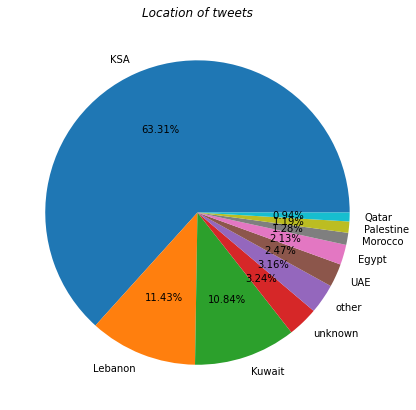

In [13]:
#graph the locations 
from matplotlib import pyplot as plt
import numpy as np
labels = df_arabic['location'].unique().tolist()
data = df_arabic['location'].value_counts().tolist()

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = labels, autopct='%1.2f%%')

plt.title(label="Location of tweets",
          loc="center",
          fontstyle='italic')
  
# show plot
plt.show()

In [14]:
#analyze the number of users who retweeted positive and negative tweets
neg_retweets = df_arabic['retweet_count'][df_arabic['retweet_count']!=0][df_arabic['label'] == '0'].sum()
print('Number of people who retweeted the negative tweets >>',neg_retweets)

pos_retweets =  df_arabic['retweet_count'][df_arabic['retweet_count']!=0][df_arabic['label'] == '1'].sum()
print('Number of people who retweeted the positive tweets >>',pos_retweets)

Number of people who retweeted the negative tweets >> 1290
Number of people who retweeted the positive tweets >> 11562


In [15]:
#analyze the number of users who liked positive and negative tweets
neg_likes = df_arabic['favorite_count'][df_arabic['favorite_count']!=0][df_arabic['label'] == '0'].sum()
print('Number of people who liked the negative tweets >>',neg_likes)

pos_likes = df_arabic['favorite_count'][df_arabic['favorite_count']!=0][df_arabic['label'] == '1'].sum()
print('Number of people who liked the positive tweets >>',pos_likes)

Number of people who liked the negative tweets >> 1278
Number of people who liked the positive tweets >> 11168


In [16]:
#analyze the number of people who replied on positive and negative tweets
neg_reply = df_arabic['reply_count'][df_arabic['reply_count']!=0][df_arabic['label'] == '0'].sum()
print('Number of people who replied on the negative tweets >>',neg_reply)

pos_reply = df_arabic['reply_count'][df_arabic['reply_count']!=0][df_arabic['label'] == '1'].sum()
print('Number of people who replied on the positive tweets >>',pos_reply)

Number of people who replied on the negative tweets >> 51
Number of people who replied on the positive tweets >> 1512


In [17]:
#analyze the number of people who quoted positive and negative tweets
neg_quote = df_arabic['quote_count'][df_arabic['quote_count']!=0][df_arabic['label'] == '0'].sum()
print('Number of people who quoted on the negative tweets >>',neg_quote)

pos_quote = df_arabic['quote_count'][df_arabic['quote_count']!=0][df_arabic['label'] == '1'].sum()
print('Number of people who quoted the positive tweets >>',pos_quote)

Number of people who quoted on the negative tweets >> 19
Number of people who quoted the positive tweets >> 219


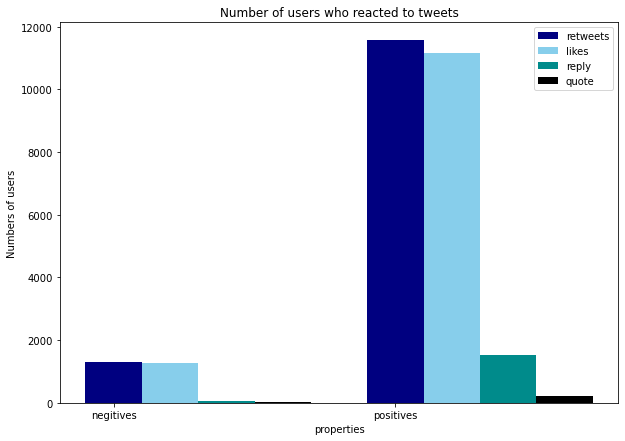

In [18]:
#plot the number of people who reacted to tweets
plt.figure(num=None, figsize=(10, 7))
Labels=['negitives','positives']
d1 = [neg_retweets, pos_retweets]
d2 = [neg_likes, pos_likes]
d3 = [neg_reply, pos_reply]
d4 = [neg_quote, pos_quote]

y_pos=np.arange(len(Labels))
plt.bar(y_pos + 0, d1,width=0.2, color = 'navy' , label='retweets')
plt.bar(y_pos + 0.2,d2, width=0.2,color = 'skyblue',label = 'likes')
plt.bar(y_pos + 0.4,d3,width=0.2, color = 'darkcyan' , label='reply')
plt.bar(y_pos + 0.6, d4,width=0.2, color = 'black' , label='quote')

plt.xticks(y_pos, Labels)
plt.legend(('retweets','likes', 'reply', 'quote'))
plt.ylabel('Numbers of users')
plt.xlabel('properties')
plt.title("Number of users who reacted to tweets")
plt.show()

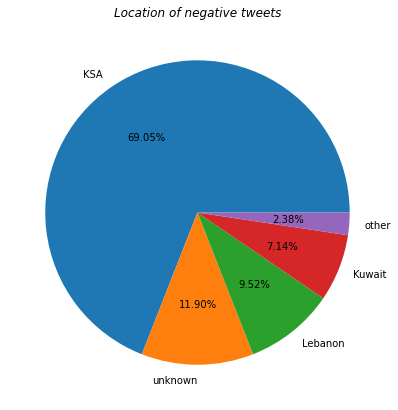

In [19]:
#graph the locations of negative tweets
from matplotlib import pyplot as plt
import numpy as np
labels = df_arabic['location'][df_arabic['label'] == '0'].unique().tolist()
data = df_arabic['location'][df_arabic['label'] == '0'].value_counts().tolist()

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = labels, autopct='%1.2f%%')

plt.title(label="Location of negative tweets",
          loc="center",
          fontstyle='italic')
  
# show plot
plt.show()

The high numbers associated with positive tweets are understandable due to the high number of positive labels in our data. However, negative tweets had high numbers of retweets and likes relative to the actual tweets numbers and lower numbers of quotes and replies, which indicates that many users are spreading their concerns about the vaccines, which in turn can indicate that large number of people need to be ensured and their concerns need to be answered in order to overcome the pandemic.

Therefore, we will be building a classification model to predict a tweet to be negative or positive in order to identify people who are sceptical about the vaccines, analyze their reasons, and design campagins to address their concerns.

#### Classifying Arabic Tweets

The data was already cleaned so we will move directly to splitting the data and preprocessing. We will be getting the text column and the labels, then we will be splitting the data into 80% train and 20% test since the data is highly imbalanced and has a small size.

In [93]:
#installing packages we will be needing later
!pip install stop-words
!pip install qalsadi

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import preprocessing as pp  # local module
import feature_extraction as fe #local module
import model as m #local module
import re
from sklearn.model_selection import train_test_split

##### Splitting and Preprocessing

In [22]:
#getting the data
df = df_arabic[['full_tweets', 'label']]

#split the data into train and test
train_corpus, test_corpus, train_label, test_label = train_test_split(df['full_tweets'],df['label'],
                                                                        test_size=0.20, random_state=42)
print('Train data shape >>', train_corpus.shape)
print('Test data shape >>', test_corpus.shape)

Train data shape >> (937,)
Test data shape >> (235,)


##### Step 1: Raw Data - Build the minimum pipeline without preprocessing

In [23]:
# Use Raw Data with TF-IDF
tv_train_features,tv_test_features = fe.tfidf_vectors(train_corpus, test_corpus,ngram_range=(1,1),max_features=None)
print('TFIDF model:> Train features shape:', tv_train_features.shape,' test features shape:', tv_test_features.shape)

TFIDF model:> Train features shape: (937, 3281)  test features shape: (235, 3281)


In [24]:
# Naïve Bayes Classifier
Raw_Train_Score=m.naive_bayes_model1(tv_train_features, train_label)
print('TF-IDF + Raw Data Train Mean ROC AUC score >> ', Raw_Train_Score)

TF-IDF + Raw Data Train Mean ROC AUC score >>  0.8997316495659037


##### Step 2: Execute each preprocessing step alone to check its impact on the same previous model¶

We tried several preprocessing methods such as stopwords removal, stemming (ISRI & and Arabic light), lemmatization, Diacritics Removal, and normalization. However, we will report the ones that improved the performance on the cross validated AUC Score.

<p style="color:blue; font-size:16px;">Lemmatization</p>

In [76]:
#Apply lemmatization on train data
norm_train_corpus = pp.normalize_corpus(corpus=train_corpus, stopwords_removal=False,
                                        stemming=False,stem ='Is', diacritics_removal=False,
                                        normalization=False,lemmatization=True)

# Use the new Data with TF-IDF
tv_train_features,tv_test_features = fe.tfidf_vectors(norm_train_corpus, test_corpus,ngram_range=(1,1),max_features=None)
print('TFIDF model:> Train features shape:', tv_train_features.shape,' Test features shape:', tv_test_features.shape)

# Naïve Bayes Classifier
Train_Score=m.naive_bayes_model1(tv_train_features, train_label)
print('TF-IDF + lemmatization Train score >> ', Train_Score)

#calculate the improvement in accuracy on test data in %
improvement = (Train_Score -  Raw_Train_Score)/ Raw_Train_Score
print('Percentage improvement in Train CV score >> ' , '%.15f' % (improvement * 100))

TFIDF model:> Train features shape: (937, 2312)  Test features shape: (235, 2312)
TF-IDF + lemmatization Train score >>  0.9195343330702446
Percentage improvement in Train CV score >>  2.200954419453306


<p style="color:blue; font-size:16px;">Stemming (Arabic Light Stemmer)</p>

In [24]:
#Apply stemming on train data
norm_train_corpus = pp.normalize_corpus(corpus=train_corpus, stopwords_removal=False,
                                        stemming=True,stem ='Al', diacritics_removal=False,
                                        normalization=False,lemmatization=False)

# Use the new Data with TF-IDF
tv_train_features,tv_test_features = fe.tfidf_vectors(norm_train_corpus, test_corpus,ngram_range=(1,1),max_features=None)
print('TFIDF model:> Train features shape:', tv_train_features.shape,' Test features shape:', tv_test_features.shape)

# Naïve Bayes Classifier
Train_Score=m.naive_bayes_model1(tv_train_features, train_label)
print('TF-IDF + stemming Train score>> ', Train_Score)

#calculate the improvement in accuracy on test data in %
improvement = (Train_Score - Raw_Train_Score)/Raw_Train_Score
print('Percentage improvement in Train CV score >> ' , '%.15f' % (improvement * 100))

TFIDF model:> Train features shape: (937, 2298)  Test features shape: (235, 2298)
TF-IDF + stemming Train score>>  0.9060975181969656
Percentage improvement in Train CV score >>  0.707529698897808


Now we will try to combine the methods in the following order to see if the improvement would increase further. We tried several orders of the preprocessing methods but we found that the following order is the best:

*   Lemmatization 
*   Stemming (Arabic Light)

In [25]:
#Apply all on train data
norm_train_corpus = pp.normalize_corpus(corpus=train_corpus, stopwords_removal=False,
                                        stemming=True,stem ='Al', diacritics_removal=False,
                                        normalization=False,lemmatization=True)


# Use the new Data with TF-IDF
tv_train_features,tv_test_features = fe.tfidf_vectors(norm_train_corpus,test_corpus,ngram_range=(1,1),max_features=None)
print('TFIDF model:> Train features shape:', tv_train_features.shape,' Test features shape:', tv_test_features.shape)

# Naïve Bayes Classifier
Train_Score=m.naive_bayes_model1(tv_train_features, train_label)
print('TF-IDF + all Train score >> ', Train_Score)

#calculate the improvement in accuracy on test data in %
improvement = (Train_Score - Raw_Train_Score)/Raw_Train_Score
print('Percentage improvement in Train CV score >> ' , '%.15f' % (improvement * 100))

TFIDF model:> Train features shape: (937, 2014)  Test features shape: (235, 2014)
TF-IDF + all Train score >>  0.9235017100762957
Percentage improvement in Train CV score >>  2.641905563937915


##### Feature extraction and models

We will now experiment with different feature engineering & classification models. We tried BOW(unigram + bigram) and TF-IDF(unigram + bigram), but we decided that the bigram was better on almost all the models.

##### BOW (bigram)

In [26]:
cv_train_features,cv_test_features = fe.bow_vectors(norm_train_corpus, test_corpus,ngram_range=(1,2),max_features=None)
print('Bigram BOW model:> Train features shape:', cv_train_features.shape,' Test features shape:', cv_test_features.shape)

Bigram BOW model:> Train features shape: (937, 6962)  Test features shape: (235, 6962)


##### Naive Bayes Complement

In [79]:
bow_cnb_auc_score= m.naive_bayes_cnb(cv_train_features, train_label ,alpha=1.0)
print('Bigram BoW + CNB Auc Score >> ', bow_cnb_auc_score)

Bigram BoW + CNB Auc Score >>  0.9052696658774007


##### Logistic Regression

In [80]:
bow_lr_auc_score=m.logistic_model(cv_train_features, train_label,C=1.0,max_iter=1000)
print('Bigram BoW + lr Auc Score >> ', bow_lr_auc_score)

Bigram BoW + lr Auc Score >>  0.932992195036394


##### KNN

In [81]:
bow_knn_auc_score=m.knn_model(cv_train_features, train_label,n_neighbors=5)
print('Bigram BoW + knn Auc Score >> ', bow_knn_auc_score)

Bigram BoW + knn Auc Score >>  0.8522195913356135


##### Decision Tree

In [82]:
bow_clf_auc_score=m.decision_tree_model(cv_train_features, train_label,max_depth=None)
print('Bigram BoW + clf Auc Score >> ', bow_clf_auc_score)

Bigram BoW + clf Auc Score >>  0.6107997895290713


##### TF-IDF (bigram)

In [83]:
tv2_train_features,tv2_test_features = fe.tfidf_vectors(norm_train_corpus, test_corpus,ngram_range=(1,2),max_features=None)
print('TFIDF model:> Train features shape:', tv2_train_features.shape,' Test features shape:', tv2_test_features.shape)

TFIDF model:> Train features shape: (937, 6962)  Test features shape: (235, 6962)


##### Naive Bayes Complement

In [84]:
tv2_cnb_auc_score=m.naive_bayes_cnb(tv2_train_features, train_label,alpha=1.0)
print('Bigram Tf-IDF + cnb Auc Score >> ', tv2_cnb_auc_score)

Bigram Tf-IDF + cnb Auc Score >>  0.9147785670437603


##### Logistic Regression

In [85]:
tv2_lr_auc_score=m.logistic_model(tv2_train_features, train_label,C=1.0,max_iter=1000)
print('Bigram Tf-IDF + lr Auc Score >> ', tv2_lr_auc_score)

Bigram Tf-IDF + lr Auc Score >>  0.9323914759273876


##### KNN

In [86]:
tv2_knn_auc_score=m.knn_model(tv2_train_features, train_label,n_neighbors=5)
print('Bigram Tf-IDF + knn Auc Score >> ', tv2_knn_auc_score)

Bigram Tf-IDF + knn Auc Score >>  0.6660277997018329


##### Decision Tree

In [87]:
tv2_clf_auc_score=m.decision_tree_model(tv2_train_features, train_label,max_depth=None)
print('Bigram Tf-IDF + clf Auc Score >> ', tv2_clf_auc_score)

Bigram Tf-IDF + clf Auc Score >>  0.6252437954924143


In [88]:
pd.DataFrame([
              ['Naive Bayes Compliment',bow_cnb_auc_score,tv2_cnb_auc_score],
              ['Logistic Regression',bow_lr_auc_score,tv2_lr_auc_score],
              ['KNN',bow_knn_auc_score,tv2_knn_auc_score],
              ['Decision Tree',bow_clf_auc_score,tv2_clf_auc_score]],
             columns=['Model', 'AUC Score(BOW Bigram)','AUC Score(Tf-Idf Bigram)'])

,Model,AUC Score(BOW Bigram),AUC Score(Tf-Idf Bigram)
0,Naive Bayes Compliment,0.905270,0.914779
1,Logistic Regression,0.932992,0.932391
2,KNN,0.852220,0.666028
3,Decision Tree,0.610800,0.625244


We conclude that the logistic regression is the best model with the highest cross validation auc score. We will apply this model on the test dataset after fine tuning the model

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [28]:
lr = LogisticRegression(penalty='l2', random_state=42)

param_distribs = {'max_iter': randint(low=100, high=1000),'C': randint(low=0.01, high=10)}

rnd_search_lr = RandomizedSearchCV(lr, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='roc_auc', random_state=42)

rnd_search_lr.fit(cv_train_features, train_label)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000260652A97C0>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000260628CA0D0>},
                   random_state=42, scoring='roc_auc')

In [29]:
final_model = rnd_search_lr.best_estimator_

##### Evaluate on test

In [30]:
#Apply all on train data
norm_test_corpus = pp.normalize_corpus(corpus=test_corpus, stopwords_removal=False,
                                        stemming=True,stem ='Al', diacritics_removal=False,
                                        normalization=False,lemmatization=True)

In [31]:
#apply the feature extraction on the test dataset
cv_train_features,cv_test_features = fe.bow_vectors(norm_train_corpus, test_corpus,ngram_range=(1,2),max_features=None)
print('Bigram BOW model:> Train features shape:', cv_train_features.shape,' Test features shape:', cv_test_features.shape)

#apply the model
predictions = final_model.predict(cv_test_features)
final_auc = roc_auc_score(test_label, predictions)
print('Final AUC Score on the test dataset >> ', np.sqrt(final_auc))

Bigram BOW model:> Train features shape: (937, 6962)  Test features shape: (235, 6962)
Final AUC Score on the test dataset >>  0.7071067811865476


As expected, the model is overfitting the data because of the small data set. However, we believe that the model will perform well if more data was gathered in detecting negative and positive tweets.

### The labeled English dataset

In [94]:
q2 = """SELECT * FROM labeled_english;"""

results_english = read_query(database_connection, q2)

In [95]:
english = []
for result in results_english:
    result = list(result)
    english.append(result)

In [96]:
columns = ['full_tweets', 'label', 'location', 'quote_count', 'reply_count', 'retweet_count','favorite_count', 'id']
df_english = pd.DataFrame(english, columns=columns)

In [97]:
#extracting the percentage of positive tweets
positives_en = df_english[df_english['label'] == '1']
print('Percentage of positive tweets >>', (len(positives_en)/df_english.shape[0])*100)

Percentage of positive tweets >> 72.2568578553616


In [98]:
mapping1 = replace.features_list(df_english['location'],10)
df_english['location'] = df_english['location'].replace(mapping1, 'other')

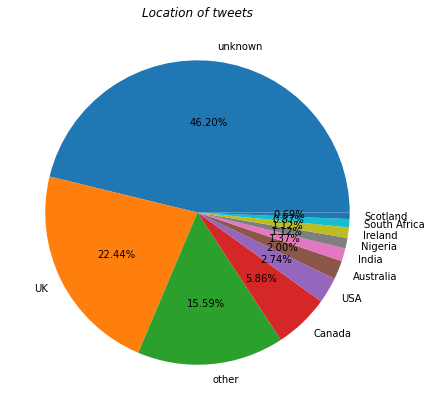

In [99]:
#graph the locations 
from matplotlib import pyplot as plt
import numpy as np
labels = df_english['location'].unique().tolist()
data = df_english['location'].value_counts().tolist()

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = labels, autopct='%1.2f%%')

plt.title(label="Location of tweets",
          loc="center",
          fontstyle='italic')
  
# show plot
plt.show()

In [100]:
#analyze the number of users who retweeted positive and negative tweets
neg_retweets1 = df_english['retweet_count'][df_english['retweet_count']!=0][df_english['label'] == '0'].sum()
print('Number of people who retweeted the negative tweets >>',neg_retweets1)

pos_retweets1 = df_english['retweet_count'][df_english['retweet_count']!=0][df_english['label'] == '1'].sum()
print('Number of people who retweeted the positive tweets >>',pos_retweets1)

Number of people who retweeted the negative tweets >> 6261
Number of people who retweeted the positive tweets >> 12648


In [101]:
#analyze the number of users who liked positive and negative tweets
neg_likes1 = df_english['favorite_count'][df_english['favorite_count']!=0][df_english['label'] == '0'].sum()
print('Number of people who liked the negative tweets >>',neg_likes1)

pos_likes1 = df_english['favorite_count'][df_english['favorite_count']!=0][df_english['label'] == '1'].sum()
print('Number of people who liked the positive tweets >>',pos_likes1)

Number of people who liked the negative tweets >> 16173
Number of people who liked the positive tweets >> 37681


In [102]:
#analyze the number of people who replied on positive and negative tweets
neg_reply1 = df_english['reply_count'][df_english['reply_count']!=0][df_english['label'] == '0'].sum()
print('Number of people who replied on the negative tweets >>',neg_reply1)

pos_reply1 = df_english['reply_count'][df_english['reply_count']!=0][df_english['label'] == '1'].sum()
print('Number of people who replied on the positive tweets >>',pos_reply1)

Number of people who replied on the negative tweets >> 1068
Number of people who replied on the positive tweets >> 2761


In [103]:
#analyze the number of people who quoted positive and negative tweets
neg_quote1 = df_english['quote_count'][df_english['quote_count']!=0][df_english['label'] == '0'].sum()
print('Number of people who quoted on the negative tweets >>',neg_quote1)

pos_quote1 = df_english['quote_count'][df_english['quote_count']!=0][df_english['label'] == '1'].sum()
print('Number of people who quoted the positive tweets >>',pos_quote1)

Number of people who quoted on the negative tweets >> 355
Number of people who quoted the positive tweets >> 951


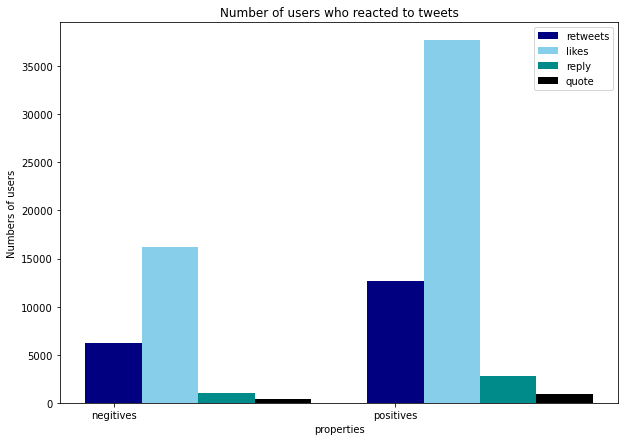

In [104]:
#plot the number of people who reacted to tweets
plt.figure(num=None, figsize=(10, 7))
Labels=['negitives','positives']
d1 = [neg_retweets1, pos_retweets1]
d2 = [neg_likes1, pos_likes1]
d3 = [neg_reply1, pos_reply1]
d4 = [neg_quote1, pos_quote1]

y_pos=np.arange(len(Labels))
plt.bar(y_pos + 0, d1,width=0.2, color = 'navy' , label='retweets')
plt.bar(y_pos + 0.2,d2, width=0.2,color = 'skyblue',label = 'likes')
plt.bar(y_pos + 0.4,d3,width=0.2, color = 'darkcyan' , label='reply')
plt.bar(y_pos + 0.6, d4,width=0.2, color = 'black' , label='quote')

plt.xticks(y_pos, Labels)
plt.legend(('retweets','likes', 'reply', 'quote'))
plt.ylabel('Numbers of users')
plt.xlabel('properties')
plt.title("Number of users who reacted to tweets")
plt.show()

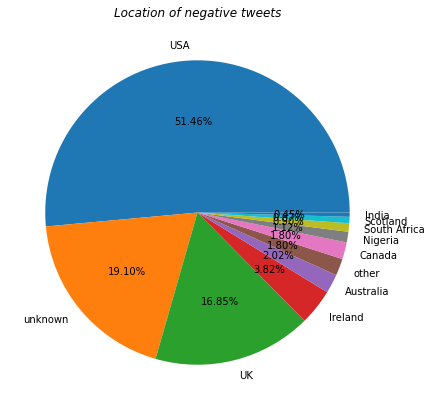

In [105]:
#graph the locations of negative tweets
from matplotlib import pyplot as plt
import numpy as np
labels = df_english['location'][df_english['label'] == '0'].unique().tolist()
data = df_english['location'][df_english['label'] == '0'].value_counts().tolist()

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = labels, autopct='%1.2f%%')

plt.title(label="Location of negative tweets",
          loc="center",
          fontstyle='italic')
  
# show plot
plt.show()

The high numbers associated with positive tweets are understandable due to the high number of positive labels in our data. However, negative tweets had high numbers of retweets and likes relative to the actual tweets numbers and lower numbers of quotes and replies, which indicates that many users are spreading their concerns about the vaccines, which in turn can indicate that large number of people need to be ensured and their concerns need to be answered in order to overcome the pandemic.

Therefore, we will be building a classification model to predict a tweet to be negative or positive in order to identify people who are sceptical about the vaccines, analyze their reasons, and design campagins to address their concerns.

#### Classifying English Tweets

The data was already cleaned so we will move directly to splitting the data and preprocessing. We will be getting the text column and the labels, then we will be splitting the data into 80% train and 20% test since the data is a bit imbalanced and has a small size.

In [106]:
import english as ep  # local module

##### Splitting and Preprocessing

In [107]:
#getting the data
df_english = df_english[['full_tweets', 'label']]

#split the data into train and test
train_corpus1, test_corpus1, train_label1, test_label1 = train_test_split(df_english['full_tweets'],df_english['label'],
                                                                      test_size=0.20, random_state=42)
print('Train data shape >>', train_corpus1.shape)
print('Test data shape >>', test_corpus1.shape)

Train data shape >> (1283,)
Test data shape >> (321,)


##### Step 1: Raw Data - Build the minimum pipeline without preprocessing

In [108]:
# Use Raw Data with TF-IDF
tv1_train_features,tv1_test_features = fe.tfidf_vectors(train_corpus1, test_corpus1,ngram_range=(1,1),max_features=None)
print('TFIDF model:> Train features shape:', tv1_train_features.shape,' test features shape:', tv1_test_features.shape)

TFIDF model:> Train features shape: (1283, 4592)  test features shape: (321, 4592)


In [109]:
# Naïve Bayes Classifier
Raw_Train_Score=m.naive_bayes_model1(tv1_train_features, train_label1)
print('TF-IDF + Raw Data Train Mean ROC AUC score >> ', Raw_Train_Score)

TF-IDF + Raw Data Train Mean ROC AUC score >>  0.7649828292627021


##### Step 2: Execute each preprocessing step alone to check its impact on the same previous model¶

We tried several preprocessing methods such as stopwords removal, stemming (Porter, lancaster & Snowball), lemmatization,text lowering, and accented chatacters. However, we will report the ones that improved the performance on the cross validated AUC Score.

<p style="color:blue; font-size:16px;">Stopword Removal</p>

In [110]:
#Apply stopword removal on train data
norm_train_corpus1 = ep.normalize_corpus(corpus=train_corpus1, 
                      accented_char_removal=False, text_lower_case=False, 
                      text_lemmatization=False,stopword_removal=True,text_stemming = False,stem='ps')

# Use the new Data with TF-IDF
tv1_train_features,tv1_test_features = fe.tfidf_vectors(norm_train_corpus1, test_corpus,ngram_range=(1,1),max_features=None)
print('TFIDF model:> Train features shape:', tv1_train_features.shape,' Test features shape:', tv1_test_features.shape)


# Naïve Bayes Classifier
Train_Score1=m.naive_bayes_model1(tv1_train_features, train_label1)
print('TF-IDF + Stopword removal Train Score >> ', Train_Score1)

#calculate the improvement in accuracy on validation data in %
improvement = (Train_Score1 - Raw_Train_Score)/ Raw_Train_Score
print('Percentage improvement in Train Score >> ' , '%.15f' % (improvement * 100))

TFIDF model:> Train features shape: (1283, 4469)  Test features shape: (235, 4469)
TF-IDF + Stopword removal Train Score >>  0.7683645844845299
Percentage improvement in Train Score >>  0.442069428550075


<p style="color:blue; font-size:16px;">Accented Char removal</p>

In [111]:
#Apply accented char removal on train data
norm_train_corpus1 = ep.normalize_corpus(corpus=train_corpus1, 
                      accented_char_removal=True, text_lower_case=False, 
                      text_lemmatization=False,stopword_removal=False,text_stemming =False,stem='ps')

# Use the new Data with TF-IDF
tv1_train_features,tv1_test_features = fe.tfidf_vectors(norm_train_corpus1, test_corpus,ngram_range=(1,1),max_features=None)
print('TFIDF model:> Train features shape:', tv1_train_features.shape,' Test features shape:', tv1_test_features.shape)


# Naïve Bayes Classifier
Train_Score1=m.naive_bayes_model1(tv1_train_features, train_label1)
print('TF-IDF + Stemmer Train Score >> ', Train_Score1)

#calculate the improvement in accuracy on validation data in %
improvement = (Train_Score1 - Raw_Train_Score)/ Raw_Train_Score
print('Percentage improvement in Train Score >> ' , '%.15f' % (improvement * 100))

TFIDF model:> Train features shape: (1283, 4587)  Test features shape: (235, 4587)
TF-IDF + Stemmer Train Score >>  0.7656648288452014
Percentage improvement in Train Score >>  0.089152273281294


Now we will try to combine the methods in the following order to see if the improvement would increase further. We tried several orders of the preprocessing methods but we found that the following order is the best:

* Accented character removal
* Stopwords removal

In [112]:
#Apply all on train data
norm_train_corpus1 = ep.normalize_corpus(corpus=train_corpus1, 
                      accented_char_removal=True, text_lower_case=False, 
                      text_lemmatization=False,stopword_removal=True,text_stemming=False,stem='ps')

# Use the new Data with TF-IDF
tv1_train_features,tv1_test_features = fe.tfidf_vectors(norm_train_corpus1, test_corpus,ngram_range=(1,1),max_features=None)
print('TFIDF model:> Train features shape:', tv1_train_features.shape,' Test features shape:', tv1_test_features.shape)


# Naïve Bayes Classifier
Train_Score1=m.naive_bayes_model1(tv1_train_features, train_label1)
print('TF-IDF + Stemmer Train Score >> ', Train_Score1)

#calculate the improvement in accuracy on validation data in %
improvement = (Train_Score1 - Raw_Train_Score)/ Raw_Train_Score
print('Percentage improvement in Train Score >> ' , '%.15f' % (improvement * 100))

TFIDF model:> Train features shape: (1283, 4464)  Test features shape: (235, 4464)
TF-IDF + Stemmer Train Score >>  0.7690310301214437
Percentage improvement in Train Score >>  0.529188460693069


##### Feature extraction and models

We will now experiment with different feature engineering & classification models. We tried BOW(unigram + bigram) and TF-IDF(unigram + bigram), but we decided that the bigram was better on almost all the models.

##### BOW (bigram)

In [113]:
cv1_train_features,cv1_test_features = fe.bow_vectors(norm_train_corpus1, test_corpus1,ngram_range=(1,2),max_features=None)
print('Bigram BOW model:> Train features shape:', cv1_train_features.shape,' Test features shape:', cv1_test_features.shape)

Bigram BOW model:> Train features shape: (1283, 15670)  Test features shape: (321, 15670)


##### Naive Bayes Complement

In [114]:
bow_cnb_auc_score1= m.naive_bayes_cnb(cv1_train_features, train_label1 ,alpha=1.0)
print('Bigram BoW + CNB Auc Score >> ', bow_cnb_auc_score1)

Bigram BoW + CNB Auc Score >>  0.7573570571934952


##### Logistic Regression

In [115]:
bow_lr_auc_score1=m.logistic_model(cv1_train_features, train_label1,C=1.0,max_iter=1000)
print('Bigram BoW + lr Auc Score >> ', bow_lr_auc_score1)

Bigram BoW + lr Auc Score >>  0.7684346591025374


##### KNN

In [116]:
bow_knn_auc_score1=m.knn_model(cv1_train_features, train_label1,n_neighbors=5)
print('Bigram BoW + knn Auc Score >> ', bow_knn_auc_score1)

Bigram BoW + knn Auc Score >>  0.6011099377432861


##### Decision Tree

In [117]:
bow_clf_auc_score1=m.decision_tree_model(cv1_train_features, train_label1,max_depth=None)
print('Bigram BoW + clf Auc Score >> ', bow_clf_auc_score1)

Bigram BoW + clf Auc Score >>  0.6097388165084666


##### TF-IDF (bigram)

In [118]:
tv1_train_features,tv1_test_features = fe.tfidf_vectors(norm_train_corpus1, test_corpus1,ngram_range=(1,2),max_features=None)
print('TFIDF model:> Train features shape:', tv1_train_features.shape,' Test features shape:', tv1_test_features.shape)

TFIDF model:> Train features shape: (1283, 15670)  Test features shape: (321, 15670)


##### Naive Bayes Complement

In [119]:
tv_cnb_auc_score1=m.naive_bayes_cnb(tv1_train_features, train_label1,alpha=1.0)
print('Bigram Tf-IDF + cnb Auc Score >> ', tv_cnb_auc_score1)

Bigram Tf-IDF + cnb Auc Score >>  0.7684524233456537


##### Logistic Regression

In [120]:
tv_lr_auc_score1=m.logistic_model(tv1_train_features, train_label1,C=1.0,max_iter=1000)
print('Bigram Tf-IDF + lr Auc Score >> ', tv_lr_auc_score1)

Bigram Tf-IDF + lr Auc Score >>  0.790137488692691


##### KNN

In [121]:
tv_knn_auc_score1=m.knn_model(tv1_train_features, train_label1,n_neighbors=5)
print('Bigram Tf-IDF + knn Auc Score >> ', tv_knn_auc_score1)

Bigram Tf-IDF + knn Auc Score >>  0.6871162166255307


##### Decision Tree

In [122]:
tv_clf_auc_score1=m.decision_tree_model(tv1_train_features, train_label1,max_depth=None)
print('Bigram Tf-IDF + clf Auc Score >> ', tv_clf_auc_score1)

Bigram Tf-IDF + clf Auc Score >>  0.5934685707970578


In [123]:
pd.DataFrame([
              ['Naive Bayes Compliment',bow_cnb_auc_score1,tv_cnb_auc_score1],
              ['Logistic Regression',bow_lr_auc_score1,tv_lr_auc_score1],
              ['KNN',bow_knn_auc_score1,tv_knn_auc_score1],
              ['Decision Tree',bow_clf_auc_score1,tv_clf_auc_score1]],
             columns=['Model', 'AUC Score(BOW Bigram)','AUC Score(Tf-Idf Bigram)'])

,Model,AUC Score(BOW Bigram),AUC Score(Tf-Idf Bigram)
0,Naive Bayes Compliment,0.757357,0.768452
1,Logistic Regression,0.768435,0.790137
2,KNN,0.601110,0.687116
3,Decision Tree,0.609739,0.593469


We conclude that the logistic regression is the best model with the highest cross validation auc score. We will apply this model on the test dataset after fine tuning the model

In [124]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [125]:
lr = LogisticRegression(penalty='l2', random_state=42)

param_distribs = {'max_iter': randint(low=100, high=1000),'C': randint(low=0.01, high=10)}

rnd_search_lr = RandomizedSearchCV(lr, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='roc_auc', random_state=42)

rnd_search_lr.fit(tv1_train_features, train_label1)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FFA06C4220>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FFA06EBB80>},
                   random_state=42, scoring='roc_auc')

In [126]:
final_model1 = rnd_search_lr.best_estimator_

###### Evaluate on test

In [127]:
#Apply all on test data
norm_test_corpus1 = ep.normalize_corpus(corpus=test_corpus1, 
                      accented_char_removal=True, text_lower_case=False, 
                      text_lemmatization=False,stopword_removal=True,text_stemming=False,stem='ps')

In [128]:
tv1_train_features,tv1_test_features = fe.tfidf_vectors(norm_train_corpus1, norm_test_corpus1,ngram_range=(1,2),max_features=None)
print('TFIDF model:> Train features shape:', tv1_train_features.shape,' Test features shape:', tv1_test_features.shape)


#apply the model
predictions1 = final_model1.predict(tv1_test_features)
final_auc1 = roc_auc_score(test_label1, predictions1)
print('Final AUC Score on the test dataset >> ', np.sqrt(final_auc1))

TFIDF model:> Train features shape: (1283, 15670)  Test features shape: (321, 15670)
Final AUC Score on the test dataset >>  0.7273268378138736


The model score on the test set is acceptable, but it is not very high. Therefore, further inspection of the model might be needed to imporve the performance.

In [129]:
#closing the connection to MYSQL
if database_connection.is_connected():
    mycursor.close()
    database_connection.close()
    print("MySQL connection is closed")

MySQL connection is closed
